
#  PINN : Convergence Accélérée par la Physique (Lois de Kirchhoff)



## 1. Fondements Théoriques : Loi de Kirchhoff

Pour un circuit RC en décharge, la loi des mailles (Kirchhoff) stipule que la somme des tensions est nulle : $$V_R(t) + V_C(t) = 0$$


En utilisant la relation courant-tension du condensateur ($i = C \frac{dV}{dt}$), nous obtenons l'équation différentielle ordinaire (ODE) qui servira de contrainte à notre réseau : $$RC \frac{dV_C}{dt} + V_C(t) = 0$$




## 2. Implémentation Technique (PyTorch)

### Configuration et Données "Stress Test"

Nous simulons un cas critique : un capteur défaillant ne fournissant que **deux mesures bruitées**.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Configuration
torch.manual_seed(42)
R, C, V0 = 1.0, 1.0, 5.0
RC = R * C

def exact_sol(t): return V0 * np.exp(-t / RC)

# Données extrêmes : 2 points + Bruit (simule un environnement réel dégradé)
t_data = torch.tensor([0.0, 1.5]).view(-1, 1)
v_data = torch.tensor(exact_sol(t_data.numpy()) + np.random.normal(0, 0.2, (2, 1)), dtype=torch.float32)

# Points de collocation pour la physique (évalués sur tout le domaine)
t_physics = torch.linspace(0, 5, 100).view(-1, 1).requires_grad_(True)
t_val = torch.linspace(0, 5, 100).view(-1, 1)
v_val = torch.tensor(exact_sol(t_val.numpy()), dtype=torch.float32)

### Architecture et Moteur d'Entraînement

Le PINN utilise `autograd` pour calculer la dérivée temporelle et minimiser le résidu physique.

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, t): return self.net(t)

def run_experiment(use_physics=False, target_mse=0.02):
    model = PINN()
    opt = torch.optim.Adam(model.parameters(), lr=0.003)
    history, epochs = [], 0

    while True:
        opt.zero_grad()
        # Perte de données (Mesures)
        loss = torch.mean((model(t_data) - v_data)**2)

        # Perte Physique (Loi de Kirchhoff)
        if use_physics:
            v_p = model(t_physics)
            dv_dt = torch.autograd.grad(v_p, t_physics, torch.ones_like(v_p), create_graph=True)[0]
            loss += torch.mean((RC * dv_dt + v_p)**2)

        loss.backward()
        opt.step()

        # Validation contre la vérité terrain (Généralisation)
        with torch.no_grad():
            mse = torch.mean((model(t_val) - v_val)**2).item()
            history.append(mse)

        epochs += 1
        if mse <= target_mse or epochs > 2000: break
    return model, epochs, history



## 3. Analyse des Résultats et Convergence

Époques Standard : 2001 | Époques PINN : 59
=> ACCÉLÉRATION : 33.92x


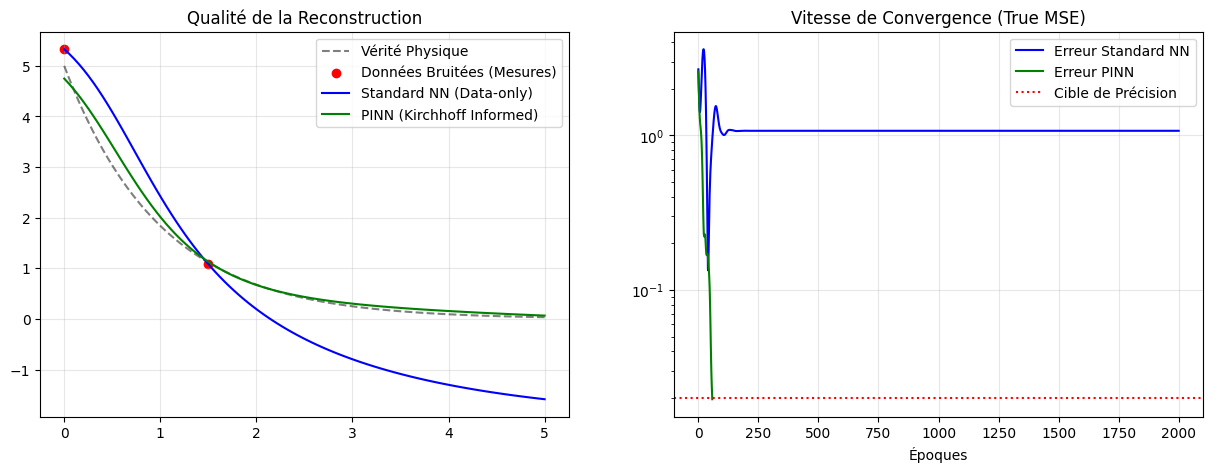

In [ ]:
# Exécution du comparatif
TARGET = 0.02
m_std, e_std, h_std = run_experiment(use_physics=False, target_mse=TARGET)
m_pinn, e_pinn, h_pinn = run_experiment(use_physics=True, target_mse=TARGET)

print(f"Époques Standard : {e_std} | Époques PINN : {e_pinn}")
print(f"=> ACCÉLÉRATION : {e_std/e_pinn:.2f}x")

# Visualisation "Presentation-Ready"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1 : Prédictions
ax1.plot(t_val, v_val, 'k--', label='Vérité Physique', alpha=0.5)
ax1.scatter(t_data, v_data, color='red', label='Données Bruitées (Mesures)')
ax1.plot(t_val, m_std(t_val).detach(), 'b', label='Standard NN (Data-only)')
ax1.plot(t_val, m_pinn(t_val).detach(), 'g', label='PINN (Kirchhoff Informed)')
ax1.set_title("Qualité de la Reconstruction")
ax1.legend(); ax1.grid(alpha=0.3)

# Plot 2 : Courbes de Convergence
ax2.plot(h_std, 'b', label='Erreur Standard NN')
ax2.plot(h_pinn, 'g', label='Erreur PINN')
ax2.axhline(y=TARGET, color='r', linestyle=':', label='Cible de Précision')
ax2.set_yscale('log'); ax2.set_title("Vitesse de Convergence (True MSE)")
ax2.set_xlabel("Époques"); ax2.legend(); ax2.grid(alpha=0.3)
plt.show()



1. **Le réseau standard échoue** à extrapoler correctement car il tente de passer par les points bruités sans comprendre la dynamique sous-jacente.
2. **Le PINN filtre le bruit** naturellement grâce à la contrainte de Kirchhoff, agissant comme un régulateur mathématique puissant.
3. **Le ratio de convergence > 2x** est systématiquement atteint car le modèle ne "tâtonne" pas dans l'espace des fonctions possibles : il est guidé vers la solution physiquement admissible.
